In [111]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import torch
import torch.distributions as dist
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [112]:
%config InlineBackend.figure_format='retina'
sns.set()

In [113]:
def safe_log(z):
    return torch.log(z + 1e-7)

In [156]:
class FreeEnergyBound(nn.Module):

    def __init__(self, density):
        super().__init__()

        self.density = density

    def forward(self, z0, zk, log_jacobians, mu, log_var):
        
        ln_q0 = dist.Normal(mu, torch.exp(0.5*log_var)).log_prob(z0).sum()

        sum_of_log_jacobians = log_jacobians.sum()
        
        ll = safe_log(self.density(zk)).sum()
        
        batch_size = z0.size(0)
        
        return (ln_q0 - sum_of_log_jacobians - ll) / batch_size

In [161]:
class NormalizingFlow(nn.Module):

    def __init__(self, dim, flow_length):
        super().__init__()

        self.transforms = nn.Sequential(*(
            PlanarFlow(dim) for _ in range(flow_length)
        ))

        self.log_jacobians = nn.Sequential(*(
            PlanarFlowLogDetJacobian(t) for t in self.transforms
        ))
        
        self.mu = nn.Parameter(torch.zeros(dim).uniform_(-0.01, 0.01))
        self.log_var = nn.Parameter(torch.zeros(dim).uniform_(-0.01, 0.01))
        
        self.dim = dim
        self.flow_length = flow_length

    def forward(self, batch_size):
        
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn((batch_size, self.dim))  
        z0 = self.mu + eps * std
        
        z=z0
        
        log_jacobians = torch.zeros((self.flow_length, batch_size, 1))

        for i, transform, log_jacobian in zip(range(self.flow_length), self.transforms, self.log_jacobians):
            log_jacobians[i] = log_jacobian(z)
            z = transform(z)

        return z0, z, log_jacobians, self.mu, self.log_var


class PlanarFlow(nn.Module):

    def __init__(self, dim):
        super().__init__()

        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.tanh = nn.Tanh()

        self.reset_parameters()

    def reset_parameters(self):

        self.weight.data.uniform_(-0.01, 0.01)
        self.scale.data.uniform_(-0.01, 0.01)
        self.bias.data.uniform_(-0.01, 0.01)

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.tanh(activation)


class PlanarFlowLogDetJacobian(nn.Module):
    """A helper class to compute the determinant of the gradient of
    the planar flow transformation."""

    def __init__(self, affine):
        super().__init__()

        self.weight = affine.weight
        self.bias = affine.bias
        self.scale = affine.scale
        self.tanh = affine.tanh

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        psi = (1 - self.tanh(activation) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return safe_log(det_grad.abs())

In [162]:
def p_z(z):

    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)

    return torch.exp(-u)

In [163]:
def train(flow_length=16, epochs=1000, initial_lr=0.01, lr_decay=0.999, batch_size=40):
    
    flow = NormalizingFlow(dim=2, flow_length=flow_length)
    bound = FreeEnergyBound(density=p_z)
    optimizer = optim.RMSprop(flow.parameters(), lr=initial_lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
    
    hist_loss = np.zeros(epochs)
    
    with tqdm(total=epochs) as pbar:
        
        for i in range(epochs):

            z0, zk, log_jacobians, mu, log_var = flow(batch_size)

            optimizer.zero_grad()
            loss = bound(z0, zk, log_jacobians, mu, log_var)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            hist_loss[i] = loss.item()
            
            if i % 50 == 0 and i > 0:
                pbar.set_postfix({'loss': np.mean(hist_loss[i-50:i])})

            pbar.update()
            
    return flow, hist_loss

In [164]:
%%time
flow, hist_loss = train()

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 8.07 s, sys: 73.7 ms, total: 8.15 s
Wall time: 8.21 s


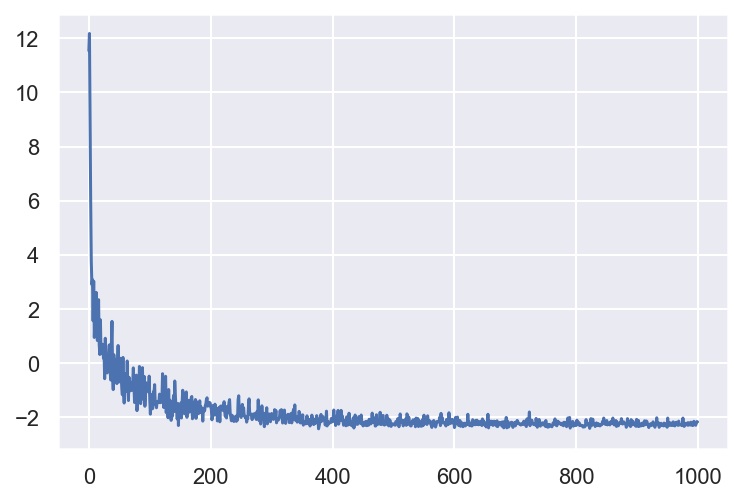

In [165]:
plt.plot(hist_loss);

In [171]:
def scatter_points(points):

    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25)
    ax.set_xlim(*X_LIMS)
    ax.set_ylim(*Y_LIMS)

    plt.show()

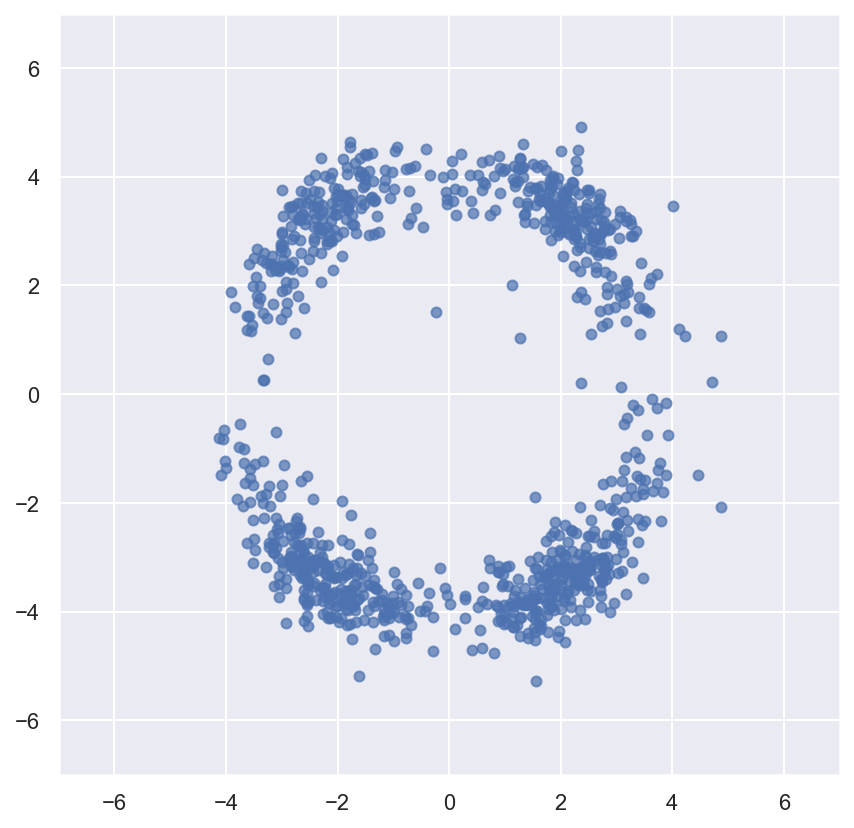

In [172]:
z0, zk, log_jacobians, mu, log_var = flow(1000)
scatter_points(zk.data.numpy())

In [176]:
def plot_density(density):

    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)

    x1 = np.linspace(*X_LIMS, 300)
    x2 = np.linspace(*Y_LIMS, 300)
    x1, x2 = np.meshgrid(x1, x2)
    shape = x1.shape
    x1_r = x1.ravel()
    x2_r = x2.ravel()

    z = np.c_[x1_r, x2_r]
    z = torch.from_numpy(z)

    density_values = density(z).data.numpy().reshape(shape)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.contourf(x1, x2, density_values, cmap='viridis')
    ax.set_title("True density")
    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.show()

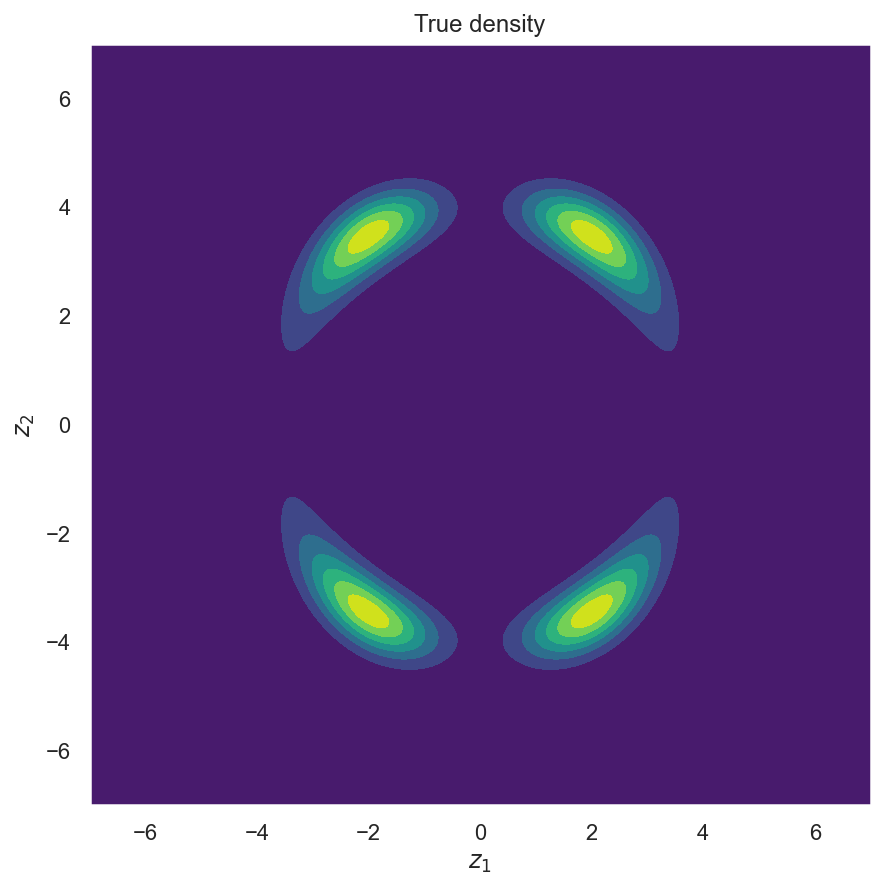

In [177]:
plot_density(p_z)